In [1]:
import torch
# Set seed
torch.manual_seed(23)

In [2]:
from src.qwen import load_qwen
model_qwen, tokenizer = load_qwen()

/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


# Part 3 (a) (Continued..)

Plan of action:

- Preprocess the data, using `load_and_preprocess`, and split the data into `train_texts`, `val_texts` and `val_text_70` $\equiv$ 900, 100 and 100 (systems). 
- The two validation sets `val_texts` and `val_text_70` have the same `shape` but:
    - In `val_texts` each system has the full 100 pairs of prey and predators
    - In `val_texts_70` each system has only the first 70 pairs of prey and predators
- We train the model on tokenised `train_texts`
- We validated the model by predicting the remaining 30 pair points in each of the 100 system in tokenised `val_texts_70`. 
- We then compare the predicted results from `val_texts_70` to the gruond truth data `val_texts` (or `true_val_values` obtained with `data_scale_split`)
- Just like for the untrained models we then want to compute MSE and RMSE 
- And report the loss/perplexity of each trained models

We are recomended to train our model up to 10,000 steps, but we have a budgeted number of flops overall for training $10^{17}$ and due to computational power required, we are going to proceed with fewer steps first, also to familiarise with the traing procedure, before increasing the number of steps and using HPC.

In synthesis:

“We trained on 900 systems, validated on 100 full sequences for loss monitoring, and evaluated forecasting performance by generating future predictions given the first 70 steps from each validation sequence.”

All the above description has been fully prepared in `set_up_lora.py`. For flops estimation we can use `total_transformer_training_flops` in `flops.py`. The reader is invited to explore and analyse every file in `src`.

In [3]:
# Import designed functions
from src.set_up_lora import*
from src.flops import*

After training the model we can determine the estimate number of flops based on training steps and other metrics.

For this part we do not want to exceed 5000 steps, otherwise we will be too close to the limited number of FLOPs allowed for training

To train the model we are going to implement the function `train_lora_model` from `set_up_lora.py`.

In [4]:
model_lora_5000, loss_lora_5000 = train_lora_model(model_qwen, tokenizer) # default steps and hyper parameters are set here

Steps 4568:  38%|███▊      | 431/1142 [01:37<02:40,  4.44it/s]


Saving LoRA Weights only (Efficitent checkpoints).

Save the LoRA adapter weights (not the full Qwen model).

In [5]:
# Extract LoRA-only weights
lora_state_dict = {
    name: param.cpu()
    for name, param in model_lora_5000.named_parameters()
    if param.requires_grad
}

#torch.save(lora_state_dict, "trained_lora_3a_5000/lora_weight_matrices_5000.pt")

In [6]:
config = model_lora_5000.config

# Parameters
num_steps = 5000
batch_size = 4
seq_len = 512
d_model = config.hidden_size
num_heads = config.num_attention_heads
num_layers = config.num_hidden_layers
intermediate_dim = 2 * d_model  # SwiGLU
lora_rank = 4  # if using LoRA

total_flops_estimate = total_transformer_training_flops(num_steps, batch_size, seq_len, num_layers, d_model, num_heads, intermediate_dim, lora_rank)

print(f'Total number of estimated FLOPs for training LoRA with {num_steps} steps:',total_flops_estimate)

Total number of estimated FLOPs for training LoRA with 5000 steps: 5983174656000000


Evaluating loss and perplexity of both tarin and validation set, there is a designed function in `set_up_lora.py`, that evaluates the perplexity and loss of the validation set, to determine the loss and perplexity of the training set, we can directly extract it from `model_lora_5000`.

### Loss and Perplexity 

In [8]:
_,val_texts, val_texts_70 = load_and_preprocess("data/lotka_volterra_data.h5")

max_steps = 5000 # CHANGE IF REQUIRED
print(f"After training with {max_steps} steps")
print(f"Training loss: {loss_lora_5000:.4f}")
perplexity_train = np.exp(loss_lora_5000)
print(f"Training perplexity: {perplexity_train:.4f}")

loss_val, ppl_val = evaluate_loss_perplexity_val(model_lora_5000, tokenizer, val_texts, 4)
print('')
print(f'Validation loss: {loss_val:.4f}')
print(f'Validation perplexity: {ppl_val:.4f}')

After training with 5000 steps
Training loss: 0.8791
Training perplexity: 2.4088


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.52it/s, avg_loss=0.7628]


Validation loss: 0.7628
Validation perplexity: 2.1443


### Forecasting Missing Pair Values

After training the model, we can start using its predictive ability with the function `prediction_after_training` also defined in `set_up_lora.py`. 
Our goal is to predict the missing 30 pairpoints in `val_texts_70`, to then compare it to the full validation set, already pre-defined in the function `prediction_after_training`. Once we have both sets we can evaluate the following metrics, error difference within each system, MSE and RMSE.

In [9]:
predicted_encoded = prediction_after_training(model_lora_5000, tokenizer, val_texts_70)

Generating predictions:   0%|          | 0/100 [00:00<?, ?it/s]/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=T

### Evaluating Metrics

To evaluate the metric mentioned above, we are going to use the designed function, `decoder_and_metrics_evaluator`, this function will return, the predicted outputs both as string-like and time=series (both outputs will be used in other functions), the true values in the validation set, and all the relevant metrics, i.e. MSE, RMSE and error in each idividual system.

In [10]:
predictions_decoded, predicted_output, true_values, MSE_values, RMSE_values, error_per_system = decoder_and_metrics_evaluator(predicted_encoded, tokenizer)

Saving results.

In [ ]:
#np.savez("trained_lora_3a_5000/predictions_decoded_trained_lora_3a.npz", *predictions_decoded)
#MSE_loaded = np.save("trained_lora_3a_5000/MSE_values_3a.npy", np.array(MSE_values))
#np.save('trained_lora_3a_5000/RMSE_values_3a', RMSE_values)
#np.savez("trained_lora_3a_5000/error_per_system_5000.npz", *error_per_system)

### Visualisation of results

There is a designed function that wraps all the functions defined in `plotting.py` into a single function, `collective_plots`

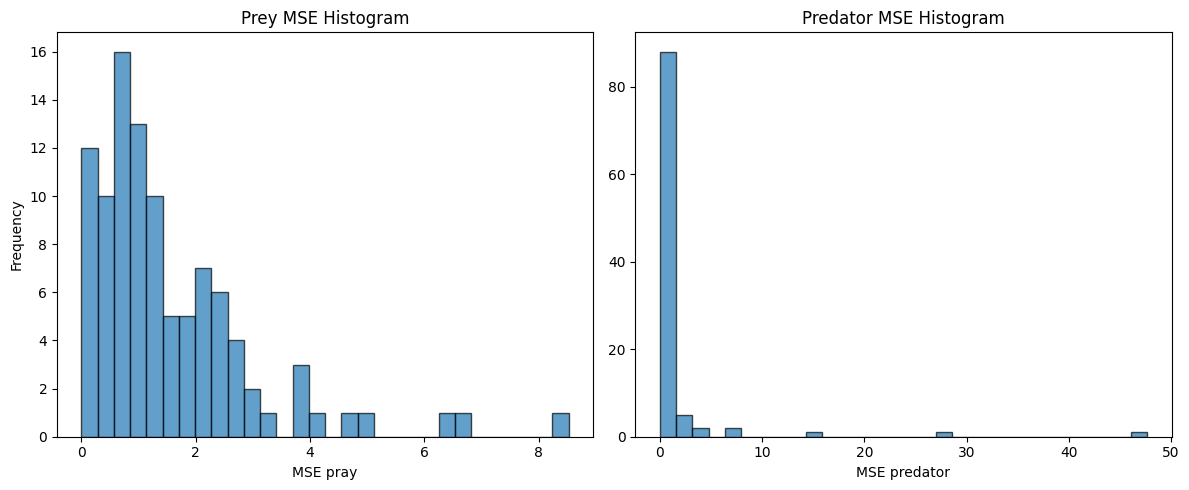

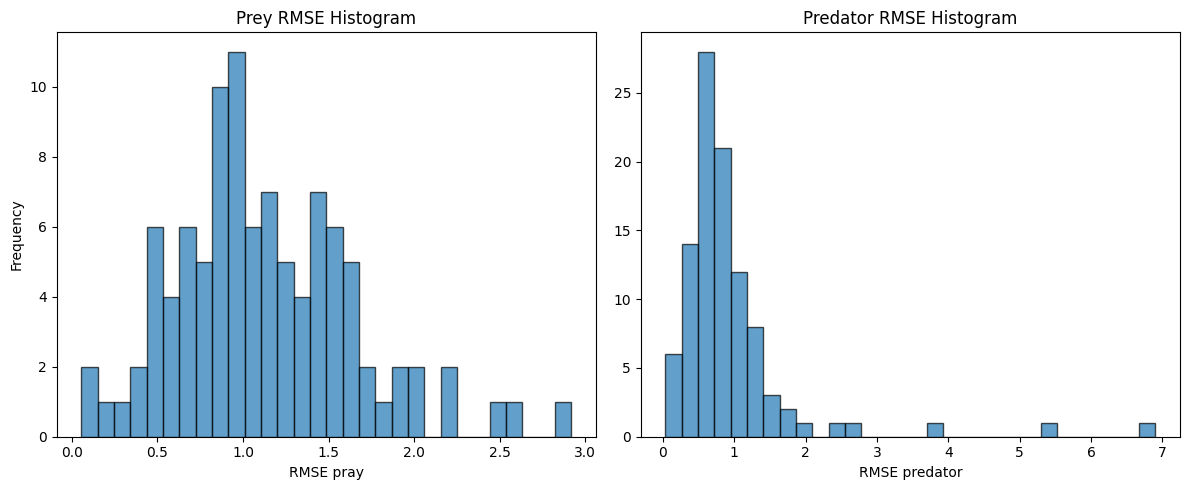

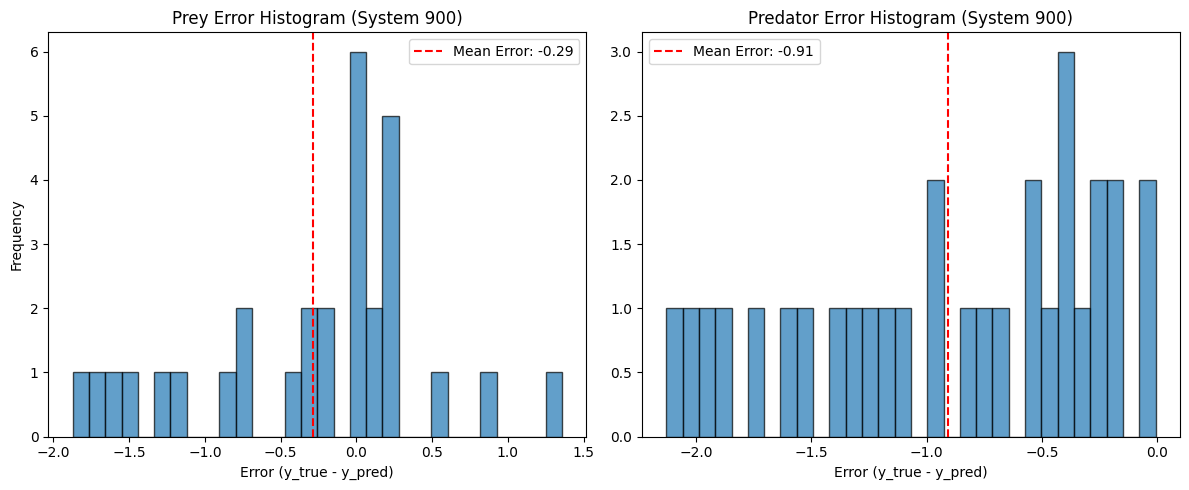

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


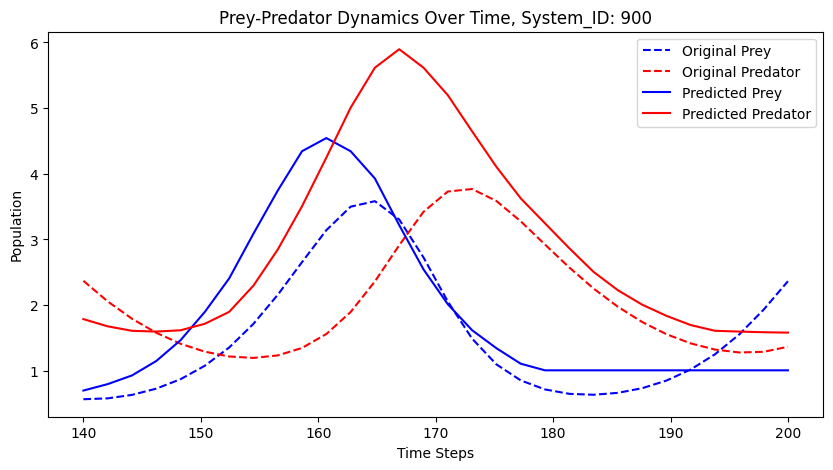

In [11]:
collective_plots(predicted_encoded, tokenizer, system_id=0, bins=30)

# Part 3 (b)

# Hyper Parameter search

In this section we are aiming to find the a set of hyper parameters, in particular "rank, learning rate" and "context lenght".

In [ ]:

import torch
# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment

In [13]:
import numpy as np
import torch
import torch.nn as nn
from src.set_up_lora import*
from src.preprocessor import*
from src.flops import*
import gc
import torch
from src.qwen import load_qwen
from src.set_up_lora import*
_, val_texts, _ = load_and_preprocess("data/lotka_volterra_data.h5")
import pandas as pd

### Strategy:

We want to sweap through all possible combuination of the following values:
- $r = (2,4,8)$ "rank"
- $lr = (10^{-5}, 5 \times 10^{-5}, 10^{4})$ "learning rate"
- $cl = 512$ "context length", i.e. fixed for now

The nested loop below will be very expensive in terms of computation, this will load Qwen2.5 nine times, if your local machine struggles to reload Qwen2.5 that many times, use the alternative code below.

After sweaping through all possible combination, we want to use the combination that provided the smallest loss/perplexity value (both will be computed within the nested loop at each itearation). Same aplies for the next HP search.

In [14]:
_,tokenizer = load_qwen() # Load tokeniser

In [15]:

results_rank_lr = []

ranks = [2, 4, 8]
lrs = [1e-5, 5e-5, 1e-4]

for r in ranks:
    for lr in lrs:
        print(f"\nTraining with r={r}, lr={lr}")

        # Load fresh model
        model, _ = load_qwen()

        # Train model and compute loss/perplexity
        trained_model, final_loss = train_lora_model(model, tokenizer, lora_rank=r, learning_rate=lr, train_steps=500)
        ppl_train = np.exp(final_loss)

        # Compute validation loss and perplexity
        val_loss, _ = evaluate_loss_perplexity_val(trained_model, tokenizer, val_texts, 4)
        ppl_val = np.exp(val_loss)
        
        # Extracting config information to determine estimate number of flops
        config = trained_model.config
        d_model = config.hidden_size
        num_heads = config.num_attention_heads
        num_layers = config.num_hidden_layers
        intermediate_dim = 2 * d_model  # SwiGLU

        # Compute total estimate of flops
        total_flops_estimate = total_transformer_training_flops(500, 4, 512, num_layers, d_model, num_heads, intermediate_dim, lora_rank=r)

        # Collecting results
        results_rank_lr.append({"rank": r, "learning_rate": lr, "Train Loss": final_loss, "Train Perplexity": ppl_train,
                                "Validation Loss": val_loss, "Validation Perplexity":ppl_val,"Estimated Flops": total_flops_estimate})
        print(f"-> Train Loss: {final_loss:.4f}, Perplexity: {ppl_train:.2f}")
        print(f"-> Validation Loss: {val_loss:.4f}, Perplexity: {ppl_val:.2f}")
        print(f"-> Estimated Flops: {total_flops_estimate}")

        # Clean up to free GPU memory
        del model
        del trained_model
        torch.cuda.empty_cache()
        gc.collect()



Training with r=2, lr=1e-05


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.93it/s, avg_loss=1.1396]


-> Train Loss: 3.4541, Perplexity: 31.63
-> Validation Loss: 1.1396, Perplexity: 3.13
-> Estimated Flops: 597788983296000

Training with r=2, lr=5e-05


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.89it/s, avg_loss=0.8949]


-> Train Loss: 2.0269, Perplexity: 7.59
-> Validation Loss: 0.8949, Perplexity: 2.45
-> Estimated Flops: 597788983296000

Training with r=2, lr=0.0001


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.89it/s, avg_loss=0.8197]


-> Train Loss: 0.8951, Perplexity: 2.45
-> Validation Loss: 0.8197, Perplexity: 2.27
-> Estimated Flops: 597788983296000

Training with r=4, lr=1e-05


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.91it/s, avg_loss=1.0173]


-> Train Loss: 0.9728, Perplexity: 2.65
-> Validation Loss: 1.0173, Perplexity: 2.77
-> Estimated Flops: 598317465600000

Training with r=4, lr=5e-05


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.86it/s, avg_loss=0.8513]


-> Train Loss: 0.8044, Perplexity: 2.24
-> Validation Loss: 0.8513, Perplexity: 2.34
-> Estimated Flops: 598317465600000

Training with r=4, lr=0.0001


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.87it/s, avg_loss=0.7866]


-> Train Loss: 0.9366, Perplexity: 2.55
-> Validation Loss: 0.7866, Perplexity: 2.20
-> Estimated Flops: 598317465600000

Training with r=8, lr=1e-05


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.85it/s, avg_loss=0.9451]


-> Train Loss: 0.8472, Perplexity: 2.33
-> Validation Loss: 0.9451, Perplexity: 2.57
-> Estimated Flops: 599374430208000

Training with r=8, lr=5e-05


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.84it/s, avg_loss=0.8080]


-> Train Loss: 0.6663, Perplexity: 1.95
-> Validation Loss: 0.8080, Perplexity: 2.24
-> Estimated Flops: 599374430208000

Training with r=8, lr=0.0001


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.72it/s, avg_loss=0.7466]


-> Train Loss: 0.7084, Perplexity: 2.03
-> Validation Loss: 0.7466, Perplexity: 2.11
-> Estimated Flops: 599374430208000


In [16]:
# Saving results as a csv file
HP_search_rlr_df = pd.DataFrame(results_rank_lr)
print(HP_search_rlr_df)
HP_search_rlr_df.to_csv("hp_tuning_results/hp_tun_rank_lr.csv")

   rank  learning_rate  Train Loss  Train Perplexity  Validation Loss  \
0     2        0.00001    3.454101         31.629828         1.139615   
1     2        0.00005    2.026943          7.590849         0.894943   
2     2        0.00010    0.895104          2.447589         0.819750   
3     4        0.00001    0.972827          2.645413         1.017263   
4     4        0.00005    0.804439          2.235443         0.851282   
5     4        0.00010    0.936563          2.551197         0.786585   
6     8        0.00001    0.847193          2.333089         0.945089   
7     8        0.00005    0.666284          1.946990         0.808013   
8     8        0.00010    0.708409          2.030757         0.746592   

   Validation Perplexity  Estimated Flops  
0               3.125564  597788983296000  
1               2.447197  597788983296000  
2               2.269932  597788983296000  
3               2.765616  598317465600000  
4               2.342649  598317465600000  
5    

After determining best hyper parameters for "rank" and "learning rate", we can procede to determine which of the three context lengths $[128, 512, 768]$ perform the best for a maximun of 2000 RLPPP steps

In [17]:

import torch
# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment

In [18]:
results_cl = []
context_lengths = [128, 512, 768]
best_r = 8
best_lr = 1e-4

for cl in context_lengths:
    print(f"\nTraining with context_lenghts = {cl}")

    # Load fresh model
    model, _ = load_qwen()
    # Train the model and compute loss
    trained_model, final_loss = train_lora_model(model, tokenizer, lora_rank=best_r, learning_rate=best_lr, max_ctx_length=cl, train_steps=500)
    ppl_train = np.exp(final_loss)


    # Computing validation loss and perplexity
    val_loss, _ = evaluate_loss_perplexity_val(trained_model, tokenizer, val_texts, 4, max_length=cl)
    ppl_val = np.exp(val_loss)
    
    # Extracting config info from the model to estimate flops
    config = trained_model.config
    d_model = config.hidden_size
    num_heads = config.num_attention_heads
    num_layers = config.num_hidden_layers
    intermediate_dim = 2 * d_model  # SwiGLU

    #  Computing total estimate of flops
    total_flops_estimate = total_transformer_training_flops(500, 4, cl, num_layers, d_model, num_heads, intermediate_dim, lora_rank=best_r)

    # Collecting results
    results_cl.append({"context_lengths": cl, "Train Loss": final_loss, "Train Perplexity": ppl_train,
                       "Validation Loss": val_loss, "Validation Perplexity": ppl_val,"Estimated Flops": total_flops_estimate})
    
    # Print results at each stage
    print(f"-> Train Loss: {final_loss:.4f}, Perplexity: {ppl_train:.2f}")
    print(f"-> Validation Loss: {val_loss:.4f}, Perplexity: {ppl_val:.2f}")
    print(f"-> Estimated Flops: {total_flops_estimate}")

    # Clean up to free GPU memory
    del model
    del trained_model
    torch.cuda.empty_cache()
    gc.collect()



Training with context_lenghts = 128


Validating: 100%|██████████| 253/253 [00:07<00:00, 33.85it/s, avg_loss=0.9951]


-> Train Loss: 1.0314, Perplexity: 2.81
-> Validation Loss: 0.9951, Perplexity: 2.71
-> Estimated Flops: 148937637888000

Training with context_lenghts = 512


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.84it/s, avg_loss=0.7459]


-> Train Loss: 0.7909, Perplexity: 2.21
-> Validation Loss: 0.7459, Perplexity: 2.11
-> Estimated Flops: 599374430208000

Training with context_lenghts = 768


Validating: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s, avg_loss=0.7522]


-> Train Loss: 0.9112, Perplexity: 2.49
-> Validation Loss: 0.7522, Perplexity: 2.12
-> Estimated Flops: 902685523968000


In [19]:
# Saving results as a csv file
HP_search_cl_df = pd.DataFrame(results_cl)
print(HP_search_cl_df)

HP_search_cl_df.to_csv("hp_tuning_results/hp_tun_cl.csv")

   context_lengths  Train Loss  Train Perplexity  Validation Loss  \
0              128    1.031441          2.805104         0.995132   
1              512    0.790858          2.205288         0.745924   
2              768    0.911201          2.487307         0.752201   

   Validation Perplexity  Estimated Flops  
0               2.705081  148937637888000  
1               2.108389  599374430208000  
2               2.121665  902685523968000  


# Part 3 (c)

In this section we will pefrom full training and validation using the best hyper-parameters determined in the previus section, determine the number of flops and all the metrics just like in previus parts, and compare resuts of the tuned model to the trained but not tuned Qwen2.5 with LoRA.

In [104]:

# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment

In [105]:
# Follecting from previus results

r_opt = 8 # Optimal Rank
lr_opt = 1e-4 # optimal Learning Rate
cl_opt = 512 # Optimal Context Length

Training Model with the above parameters (and determine loss/perplexity)

In [106]:
model_opt, tokenizer = load_qwen() # Loading Qwen2.5

In [107]:
model_opt_train, loss_best_train = train_lora_model(model_opt, tokenizer, lora_rank=r_opt, learning_rate=lr_opt, batch_size=4, max_ctx_length=cl_opt,train_steps=5000) # Training model

Steps 4568:  38%|███▊      | 431/1142 [02:16<03:45,  3.15it/s]


Collecting train and validation loss/perplexity and FLOPs

In [112]:
import pandas as pd

In [113]:
# Computing validation loss and perplexity

_, val_texts, _ = load_and_preprocess("data/lotka_volterra_data.h5") # Reloading validation set

ppl_best_train = np.exp(loss_best_train) # Perplexity on trained model

# Validation loss and perplexity of best model
loss_best_val, ppl_best_val = evaluate_loss_perplexity_val(model_opt_train, tokenizer, val_texts, 4,  max_length=cl_opt)

# Extracting config info from the model to estimate flops
config = model_opt_train.config
d_model = config.hidden_size
num_heads = config.num_attention_heads
num_layers = config.num_hidden_layers
intermediate_dim = 2*d_model  # SwiGLU

#  Computing total estimate of flops
total_flops_for_best_model = total_transformer_training_flops(5000, 4, cl_opt, num_layers, d_model, num_heads, intermediate_dim, lora_rank=r_opt)

# collecting results
collecting_results = [[loss_best_train, ppl_best_train, 
                       loss_best_val, ppl_best_val,
                      total_flops_for_best_model]
                      ]
columns = ["Training Loss", "Training Perplexity", "Validation Loss", "Validation Perplexity", "FLOPs"]

# Collecting results in pd.DataFrame

best_model_results_df = pd.DataFrame(collecting_results, columns=columns)
print("Metric results from best model:")
print("")
print(best_model_results_df)

# Save results

best_model_results_df.to_csv("best_model_results/best_model_trval_loss_ppl.csv")

Validating: 100%|██████████| 75/75 [00:20<00:00,  3.71it/s, avg_loss=0.5959]

Metric results from best model:

   Training Loss  Training Perplexity  Validation Loss  Validation Perplexity  \
0       0.582722             1.790908         0.595908               1.814679   

              FLOPs  
0  5993744302080000  


Using best model for predictions

In [114]:
# Prediction after training
_,_,val_texts_70 = load_and_preprocess("data/lotka_volterra_data.h5") # Reload 70% of validation set

# Compute prediction
predicted_encoded_best = prediction_after_training(model_opt_train, tokenizer, val_texts_70)

Generating predictions:   0%|          | 0/100 [00:00<?, ?it/s]/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=T

In [116]:
predictions_decoded_best = []

for i in range(len(predicted_encoded_best)):
    decoded_output_best = string_to_array(tokenizer.decode(predicted_encoded_best[i][0], skip_special_tokens=True))
    predictions_decoded_best.append(decoded_output_best)

In [117]:
predictions_decoded_best

[array([[3.171, 4.15 ],
        [2.013, 4.616],
        [1.211, 4.559],
        [0.764, 4.166],
        [0.534, 3.647],
        [0.42 , 3.123],
        [0.369, 2.647],
        [0.359, 2.234],
        [0.38 , 1.888],
        [0.432, 1.602],
        [0.52 , 1.373],
        [0.655, 1.194],
        [0.853, 1.061],
        [1.134, 0.972],
        [1.522, 0.93 ],
        [2.037, 0.941],
        [2.678, 1.022],
        [3.394, 1.201],
        [4.053, 1.526],
        [4.422, 2.051],
        [4.25 , 2.788],
        [3.491, 3.604],
        [2.459, 4.207],
        [1.582, 4.377],
        [1.02 , 4.163],
        [0.705, 3.746],
        [0.539, 3.27 ],
        [0.458, 2.809],
        [0.429, 2.397],
        [0.438, 2.042],
        [0.482, 1.746],
        [0.562, 1.505],
        [0.688, 1.315],
        [0.872, 1.173],
        [1.132, 1.077],
        [1.487, 1.028],
        [1.951, 1.033],
        [2.522, 1.106],
        [3.154, 1.27 ],
        [3.737, 1.565],
        [4.08 , 2.03 ],
        [3.984, 

In [118]:
_, true_val_values, _ = data_scale_split("data/lotka_volterra_data.h5")

predicted_output_best = []
true_values = []
# Collecting the last 30 pair from each array
for i in range(len(predictions_decoded_best)):
    sub_output = predictions_decoded_best[i]
    sub_output_min_30 = sub_output[70:100]
    true_v = true_val_values[i]
    true_v_min_30 = true_v[70:]
    predicted_output_best.append(sub_output_min_30)
    true_values.append(true_v_min_30)

In [120]:
true_values

[array([[0.567, 2.37 ],
        [0.58 , 2.057],
        [0.633, 1.793],
        [0.728, 1.579],
        [0.872, 1.412],
        [1.077, 1.291],
        [1.354, 1.218],
        [1.715, 1.196],
        [2.157, 1.234],
        [2.655, 1.348],
        [3.141, 1.56 ],
        [3.499, 1.895],
        [3.583, 2.361],
        [3.304, 2.912],
        [2.726, 3.421],
        [2.055, 3.73 ],
        [1.49 , 3.768],
        [1.098, 3.586],
        [0.854, 3.277],
        [0.716, 2.923],
        [0.649, 2.573],
        [0.635, 2.253],
        [0.664, 1.975],
        [0.735, 1.743],
        [0.851, 1.557],
        [1.02 , 1.417],
        [1.252, 1.323],
        [1.555, 1.279],
        [1.931, 1.289],
        [2.364, 1.366]], dtype=float32),
 array([[2.073, 1.025],
        [2.309, 0.948],
        [2.598, 0.906],
        [2.928, 0.9  ],
        [3.278, 0.933],
        [3.618, 1.008],
        [3.901, 1.131],
        [4.074, 1.303],
        [4.088, 1.52 ],
        [3.92 , 1.756],
        [3.596, 1.97 ],

In [125]:
empty_list = []


for i in range(len(true_values)):
     empty_list.append(len(predicted_output_best[i]))

In [127]:
print(empty_list)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 0, 30, 30, 30, 15, 30, 30, 30, 30, 30, 0, 30, 30, 15, 0, 0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 19, 30, 30, 30, 30, 30, 20, 30, 0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 15, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 21, 30, 30, 30, 30, 19, 30, 30, 30, 30]


In [128]:
print(len(empty_list))

100


In [129]:
MSE_values_best = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output_best[i]), len(true_values[i]))

    if min_length !=30:
        continue
    pr_out = predicted_output_best[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values_best.append([mse_prey, mse_predator])

In [130]:



string_to_array = Preprocessor.string_to_array

_, true_val_values, _ = data_scale_split("data/lotka_volterra_data.h5")

predictions_decoded_best = []

for i in range(len(predicted_encoded_best)):
    decoded_output_best = string_to_array(tokenizer.decode(predicted_encoded_best[i][0], skip_special_tokens=True))
    predictions_decoded_best.append(decoded_output_best)


predicted_output_best = []
true_values = []
# Collecting the last 30 pair from each array
for i in range(len(predictions_decoded_best)):
    sub_output = predictions_decoded_best[i]
    sub_output_min_30 = sub_output[70:100]
    true_v = true_val_values[i]
    true_v_min_30 = true_v[70:]
    predicted_output_best.append(sub_output_min_30)
    true_values.append(true_v_min_30)

    # Computing MSE
MSE_values_best = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output_best[i]), len(true_values[i]))
    if min_length !=30:
        continue
    pr_out = predicted_output_best[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values_best.append([mse_prey, mse_predator])

# Computing RMSE
RMSE_values_best = np.sqrt(MSE_values_best)

# Computing the error for each system

error_per_system_best = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output_best[i]), len(true_values[i]))

    if min_length !=30:
        continue
    pr_out = predicted_output_best[i][:min_length]
    true_val = true_values[i][:min_length]

    # Computing errors
    prey_error = true_val[:,0] - pr_out[:,0]
    predator_error = true_val[:,1] - pr_out[:,1]
    
    # Collecting errors into a list
    error_per_system_best.append([prey_error, predator_error])



Determining metrics from predictions, MSE, RMSE and error in each system

Saving metrics

In [131]:
np.savez("best_model_results/predictions_decoded_best.npz", *predictions_decoded_best)
MSE_loaded = np.save("best_model_results/MSE_values_best.npy", np.array(MSE_values_best))
np.save('best_model_results/RMSE_values_best', RMSE_values_best)
np.savez("best_model_results/error_per_system_best.npz", *error_per_system_best)

### Visualisation

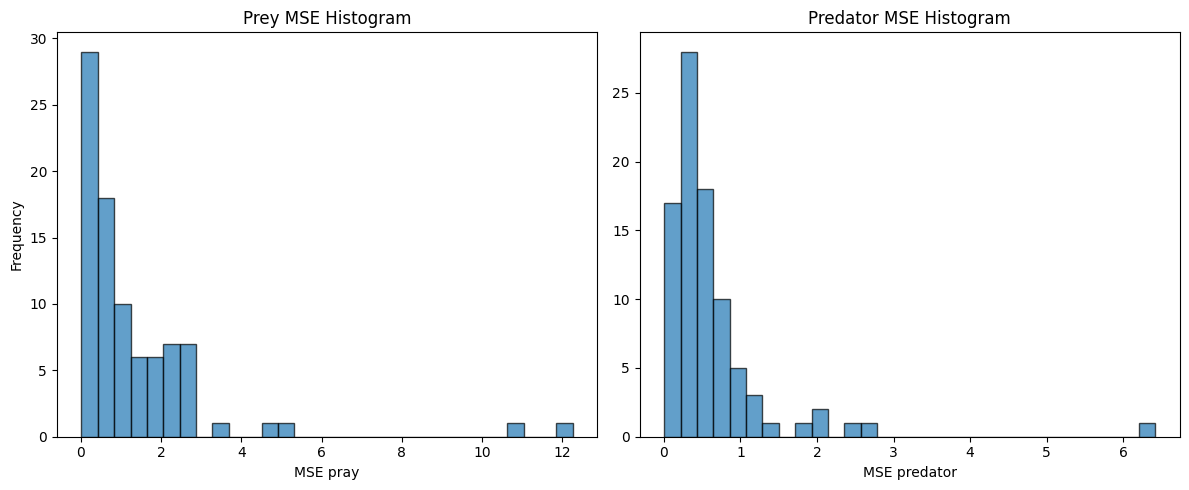

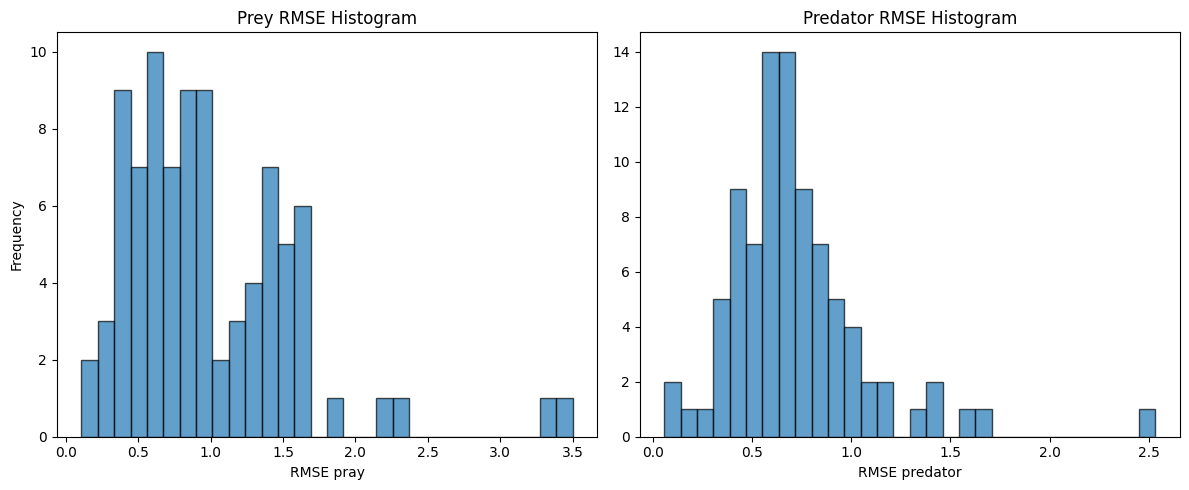

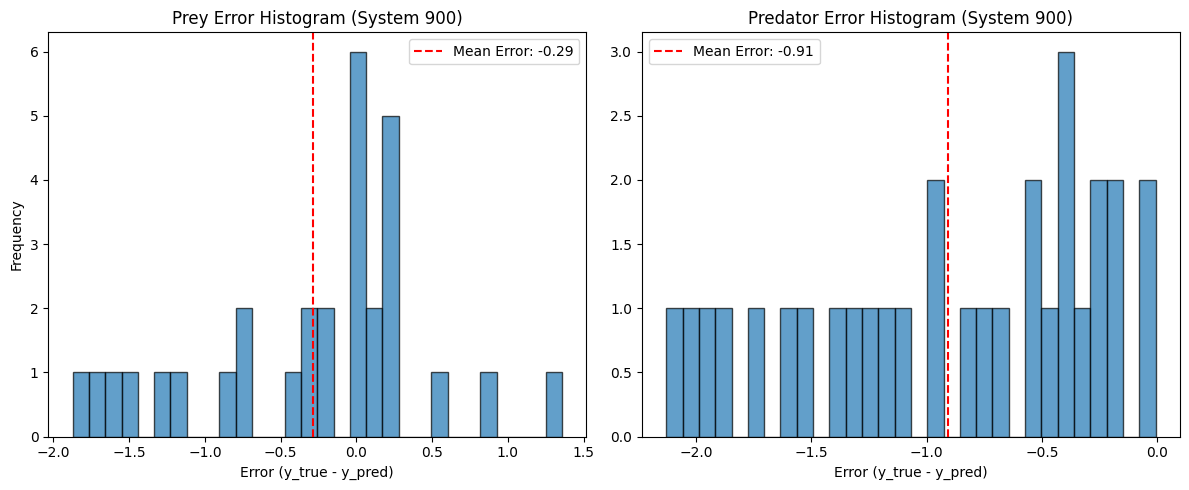

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


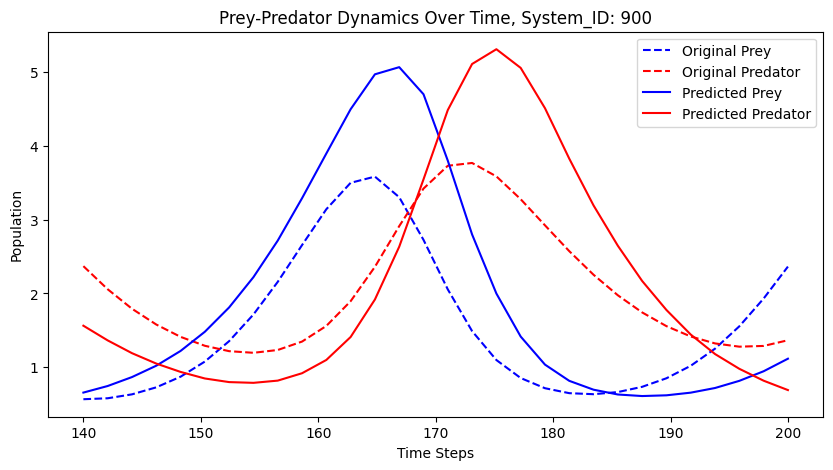

In [132]:
#collective_plots(predicted_encoded_best, tokenizer)


df_MSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values_best)),  
    "MSE for prey": np.array(MSE_values_best)[:, 0],  # Flatten prey values
    "MSE for predator": np.array(MSE_values_best)[:, 1]  # Flatten predator values
})
df_RMSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values_best)),  
    "RMSE for prey": RMSE_values_best[:, 0],  # Flatten prey values
    "RMSE for predator": RMSE_values_best[:, 1]  # Flatten predator values
})

PlotProject.plot_hist_MSE(df_MSE_values,bins=30) # Plotting MSE distribution
PlotProject.plot_hist_RMSE(df_RMSE_values,bins=30) # Plotting RMSE distribution
PlotProject.plot_error_hist_system(error_per_system, 0, bins=30)
pred_vs_true_visualisation(predictions_decoded_best, true_values, 0)

# Raw Performance experiment 

In [75]:

# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment

In [76]:
# Follecting from previus results

r_opt = 8 # Optimal Rank
lr_opt = 1e-4 # optimal Learning Rate
cl_opt = 512 # Optimal Context Length


In [77]:
model_opt, tokenizer = load_qwen() # Loading Qwen2.5

In [78]:
model_opt_train, loss_best_train = train_lora_model(model_opt, tokenizer, lora_rank=r_opt, learning_rate=lr_opt, batch_size=4, max_ctx_length=cl_opt,train_steps=30000) # Training model

Steps 29692:  27%|██▋       | 307/1142 [02:45<07:30,  1.85it/s]


In [100]:
# Computing validation loss and perplexity

_, val_texts, _ = load_and_preprocess("data/lotka_volterra_data.h5") # Reloading validation set

ppl_best_train = np.exp(loss_best_train) # Perplexity on trained model

# Validation loss and perplexity of best model
loss_best_val, ppl_best_val = evaluate_loss_perplexity_val(model_opt_train, tokenizer, val_texts, 4,  max_length=cl_opt)

# Extracting config info from the model to estimate flops
config = model_opt_train.config
d_model = config.hidden_size
num_heads = config.num_attention_heads
num_layers = config.num_hidden_layers
intermediate_dim = 2*d_model  # SwiGLU

#  Computing total estimate of flops
total_flops_for_best_model = total_transformer_training_flops(30000, 4, cl_opt, num_layers, d_model, num_heads, intermediate_dim, lora_rank=r_opt)

# collecting results
collecting_results = [[loss_best_train, ppl_best_train, 
                       loss_best_val, ppl_best_val,
                      total_flops_for_best_model]
                      ]
columns = ["Training Loss", "Training Perplexity", "Validation Loss", "Validation Perplexity", "FLOPs"]

# Collecting results in pd.DataFrame

best_model_results_df = pd.DataFrame(collecting_results, columns=columns)
print("Metric results from best model:")
print("")
print(best_model_results_df)

# Save results

best_model_results_df.to_csv("best_model_results/best_model_trval_loss_ppl.csv")

Validating: 100%|██████████| 75/75 [00:54<00:00,  1.38it/s, avg_loss=0.4984]

Metric results from best model:

   Training Loss  Training Perplexity  Validation Loss  Validation Perplexity  \
0        0.48839              1.62969         0.498352               1.646007   

               FLOPs  
0  35962465812480000  


In [80]:
# Prediction after training
_,_,val_texts_70 = load_and_preprocess("data/lotka_volterra_data.h5") # Reload 70% of validation set

# Compute prediction
predicted_encoded_best = prediction_after_training(model_opt_train, tokenizer, val_texts_70)

Generating predictions:   0%|          | 0/100 [00:00<?, ?it/s]/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=T

In [96]:
string_to_array = Preprocessor.string_to_array

_, true_val_values, _ = data_scale_split("data/lotka_volterra_data.h5")

predictions_decoded_best = []

for i in range(len(predicted_encoded_best)):
    decoded_output_best = string_to_array(tokenizer.decode(predicted_encoded_best[i][0], skip_special_tokens=True))
    predictions_decoded_best.append(decoded_output_best)


predicted_output_best = []
true_values = []
# Collecting the last 30 pair from each array
for i in range(len(predictions_decoded_best)):
    sub_output = predictions_decoded_best[i]
    sub_output_min_30 = sub_output[70:100]
    true_v = true_val_values[i]
    true_v_min_30 = true_v[70:]
    predicted_output_best.append(sub_output_min_30)
    true_values.append(true_v_min_30)

    # Computing MSE
MSE_values_best = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output_best[i]), len(true_values[i]))
    pr_out = predicted_output_best[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values_best.append([mse_prey, mse_predator])

# Computing RMSE
RMSE_values_best = np.sqrt(MSE_values_best)

# Computing the error for each system

error_per_system_best = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output_best[i]), len(true_values[i]))
    pr_out = predicted_output_best[i][:min_length]
    true_val = true_values[i][:min_length]

    # Computing errors
    prey_error = true_val[:,0] - pr_out[:,0]
    predator_error = true_val[:,1] - pr_out[:,1]
    
    # Collecting errors into a list
    error_per_system_best.append([prey_error, predator_error])

In [97]:
print(type(predicted_encoded_best[0]))

<class 'torch.Tensor'>


In [ ]:
#np.savez("raw_performance_experiment_results/predictions_decoded_best.npz", *predictions_decoded_best)
#MSE_loaded = np.save("raw_performance_experiment_results/MSE_values_best.npy", np.array(MSE_values_best))
#np.save('raw_performance_experiment_results/RMSE_values_best', RMSE_values_best)
#np.savez("raw_performance_experiment_results/error_per_system_best.npz", *error_per_system_best)

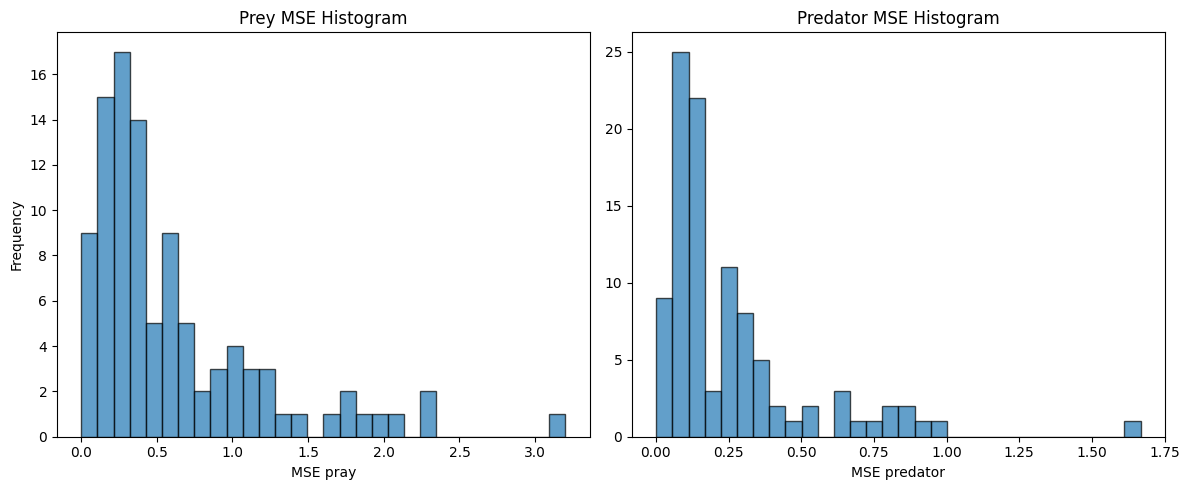

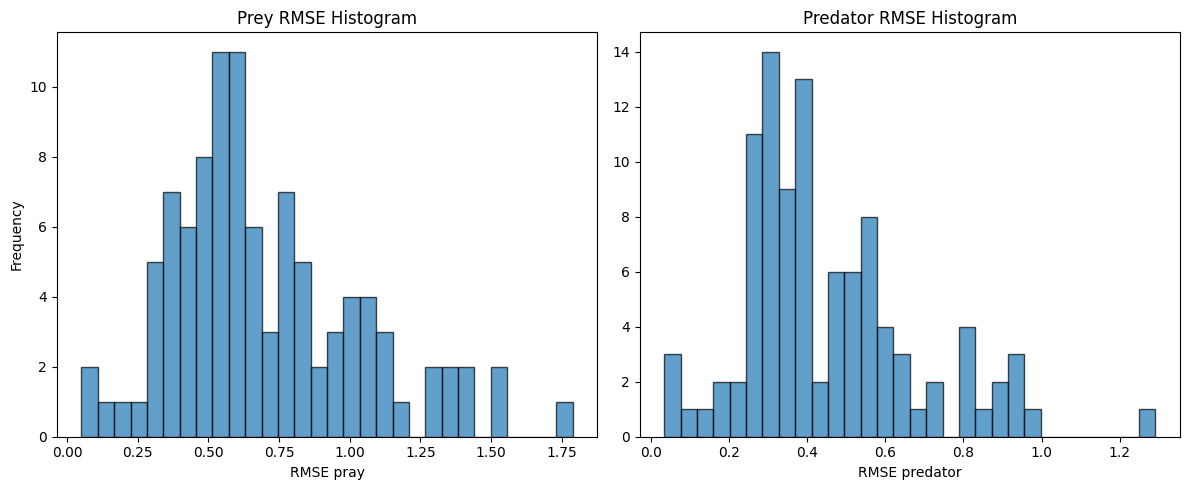

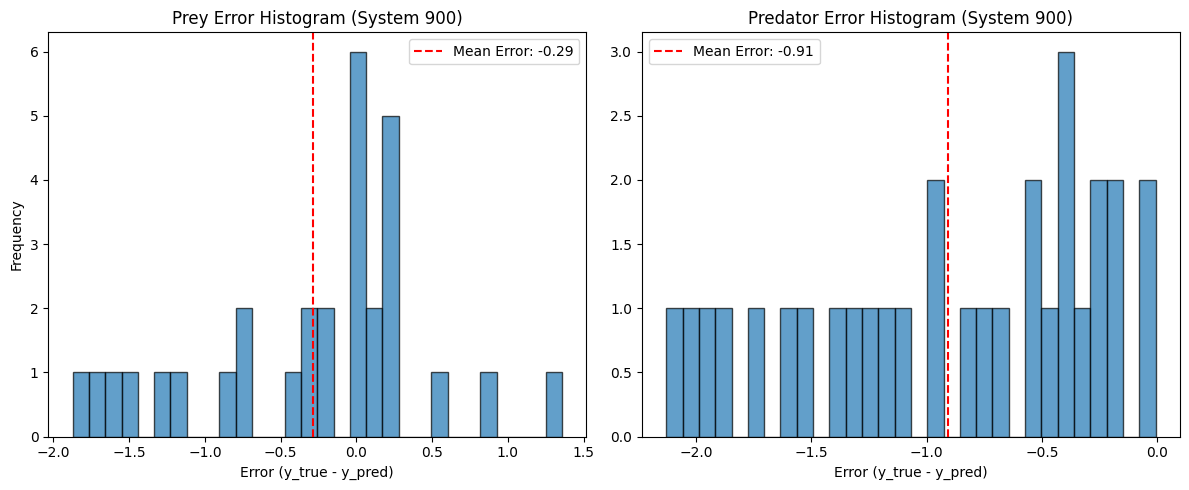

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


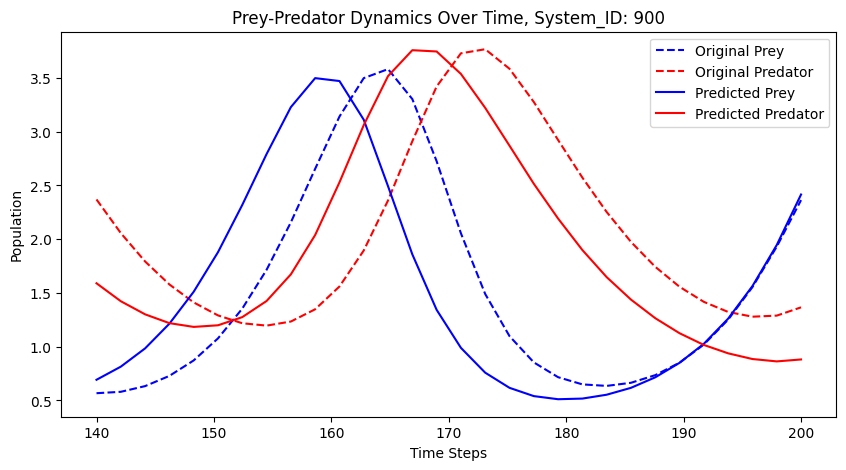

In [ ]:
#collective_plots(predicted_encoded_best, tokenizer)


df_MSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values_best)),  
    "MSE for prey": np.array(MSE_values_best)[:, 0],  # Flatten prey values
    "MSE for predator": np.array(MSE_values_best)[:, 1]  # Flatten predator values
})
df_RMSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values_best)),  
    "RMSE for prey": RMSE_values_best[:, 0],  # Flatten prey values
    "RMSE for predator": RMSE_values_best[:, 1]  # Flatten predator values
})

PlotProject.plot_hist_MSE(df_MSE_values,bins=30) # Plotting MSE distribution
PlotProject.plot_hist_RMSE(df_RMSE_values,bins=30) # Plotting RMSE distribution
PlotProject.plot_error_hist_system(error_per_system, 0, bins=30)
pred_vs_true_visualisation(predictions_decoded_best, true_values, 0)

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


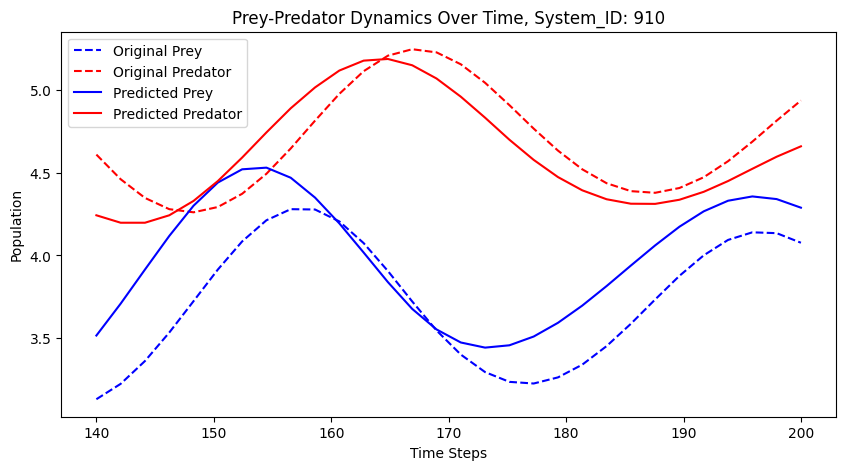

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


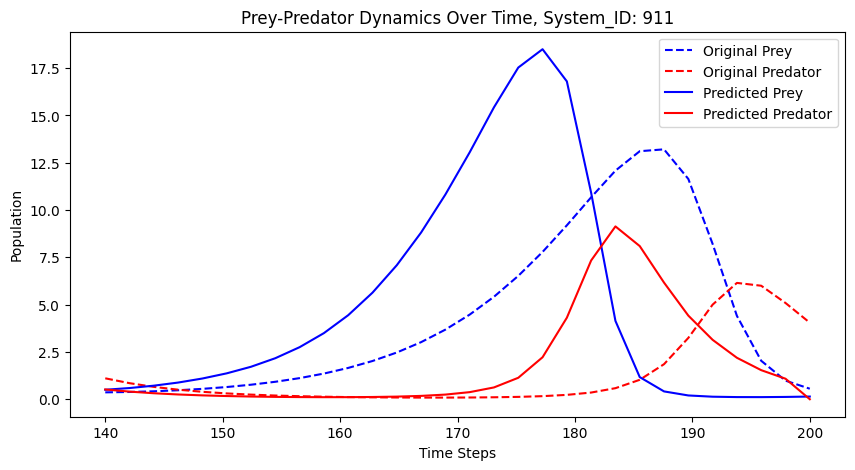

Decoded prediction shape: (101, 2)
True dataset shape: (30, 2)


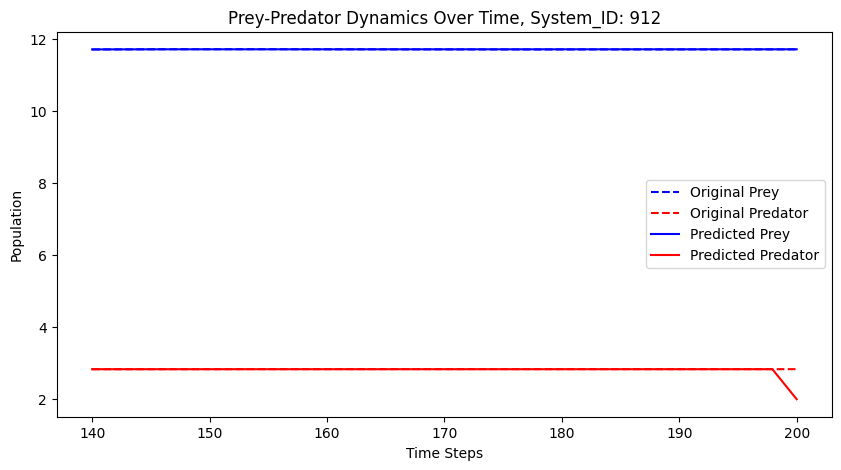

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


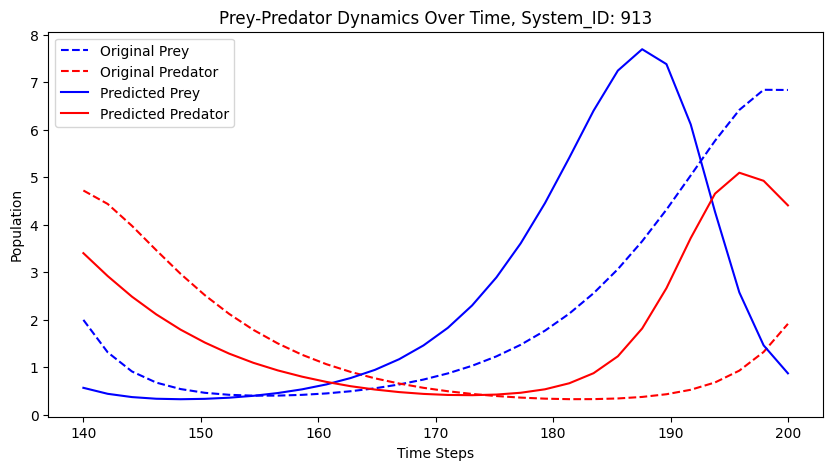

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


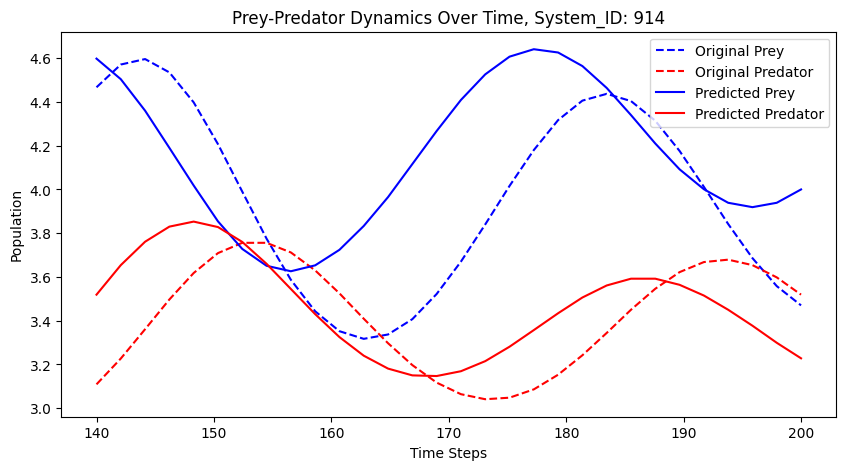

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


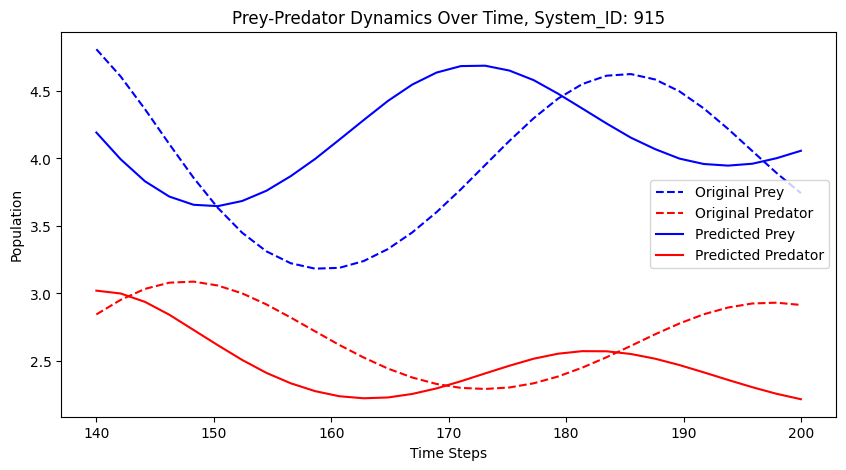

Decoded prediction shape: (102, 2)
True dataset shape: (30, 2)


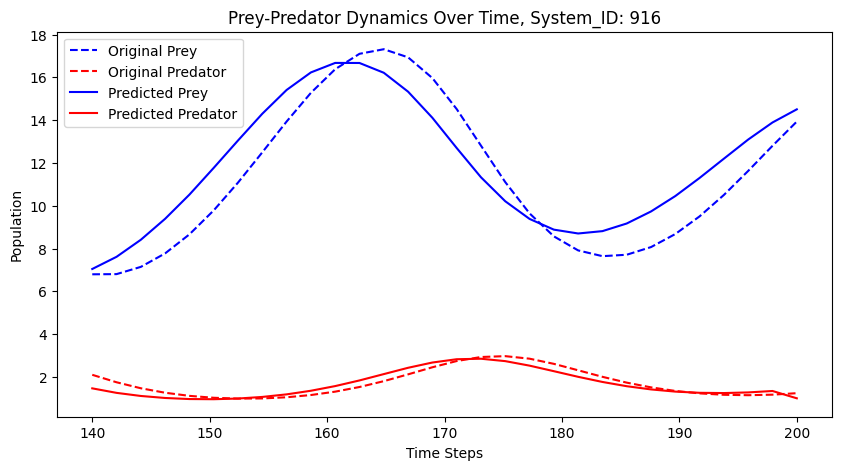

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


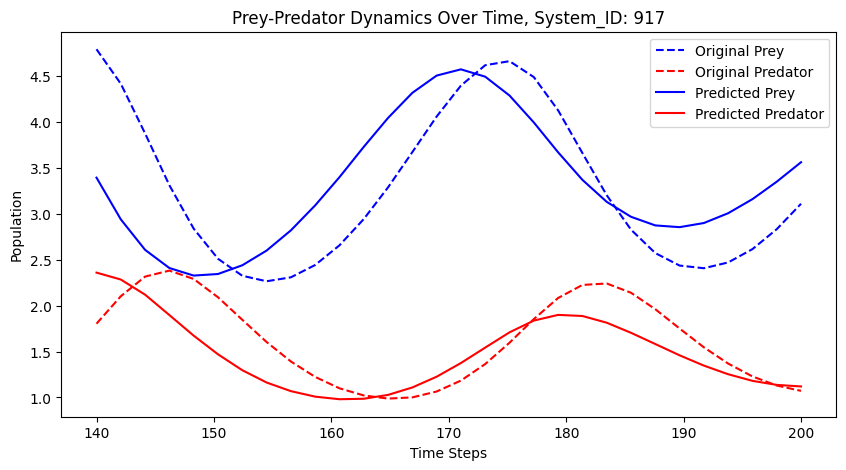

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


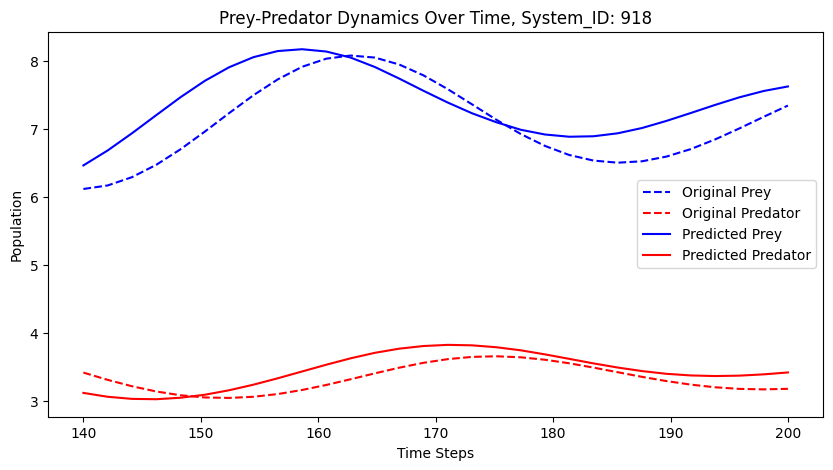

Decoded prediction shape: (101, 2)
True dataset shape: (30, 2)


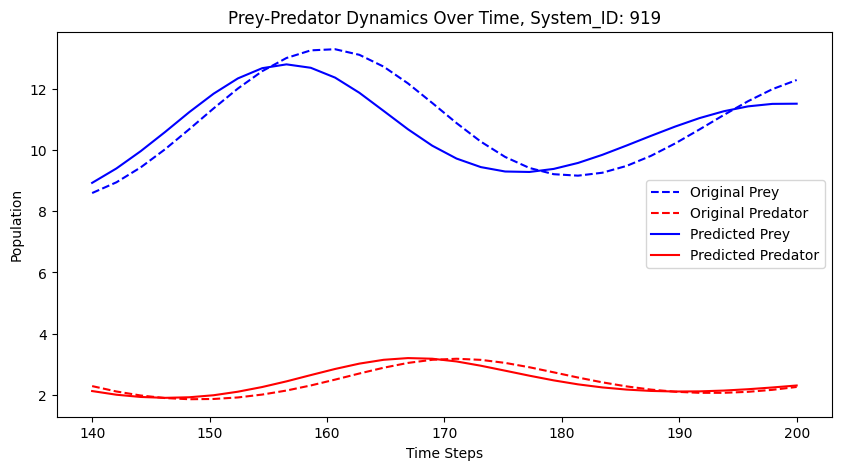

In [103]:
for i in range(10, 20):
    pred_vs_true_visualisation(predictions_decoded_best, true_values, i)
